In [2]:
#| default_exp single

In [4]:
import jax
import jax.numpy as jnp
from flax.struct import dataclass
from typing import List, Tuple

# --- Your Provided Code (unchanged) ---

@dataclass(frozen=True)
class Population:
    """The one and only dynamic state object. It is lean and immutable."""
    geno: jnp.ndarray  # Shape: (n_ind, n_chr, ploidy, n_loci), Dtype: int8
    meta: jnp.ndarray  # Shape: (n_ind, 4), Dtype: int32 -> [id, mother_id, father_id, birth_gen]


@dataclass(frozen=True)
class Trait:
    """Parameters for a single additive trait."""
    qtl_chromosome: jnp.ndarray # Shape: (n_qtl,) -> which chromosome each QTL is on
    qtl_position: jnp.ndarray   # Shape: (n_qtl,) -> which locus index each QTL is on
    qtl_effects: jnp.ndarray    # Shape: (n_qtl,) -> the additive effect of each QTL

@dataclass(frozen=True)
class SimConfig:
    """Static configuration for the simulation."""
    n_chr: int
    n_loci_per_chr: int
    ploidy: int
    genetic_map: jnp.ndarray # Shape: (n_chr, n_loci_per_chr) -> crossover probabilities
    traits: List[Trait]      # A list of trait architectures


def create_founders(
    key: jax.random.PRNGKey,
    n_ind: int,
    n_chr: int,
    n_loci_per_chr: int,
    ploidy: int = 2,
    chr_len_cm: float = 100.0
) -> Tuple[Population, jnp.ndarray]:
    """
    Creates a dense founder population and a corresponding genetic map.

    Returns:
        A tuple of (Population, genetic_map). The Population object is a lean
        PyTree with no padding, and the genetic_map is a JAX array.
    """
    key_geno, _ = jax.random.split(key)

    # 1. Generate dense genetic data
    founder_geno = jax.random.randint(
        key_geno, (n_ind, n_chr, ploidy, n_loci_per_chr), 0, 2, dtype=jnp.uint8
    )

    # 2. Create dense metadata
    ids = jnp.arange(n_ind, dtype=jnp.int32)
    mother_ids = jnp.full(n_ind, -1, dtype=jnp.int32)
    father_ids = jnp.full(n_ind, -1, dtype=jnp.int32)
    birth_gens = jnp.zeros(n_ind, dtype=jnp.int32)
    founder_meta = jnp.stack([ids, mother_ids, father_ids, birth_gens], axis=-1)

    # 3. Generate a uniform genetic map
    # This map represents recombination probability between adjacent loci.
    # For simplicity, we'll make it uniform for now.
    recomb_rate = (chr_len_cm / 100) / n_loci_per_chr
    genetic_map = jnp.full((n_chr, n_loci_per_chr), recomb_rate)


    # 4. Instantiate the Population PyTree and return with the map
    population = Population(
        geno=founder_geno,
        meta=founder_meta
    )

    return population, genetic_map

# --- Workflow Implementation ---

# 1. Define Simulation Hyperparameters
N_FOUNDERS = 50
N_CHR = 10
N_LOCI_PER_CHR = 100
PLOIDY = 2
N_QTL = 200 # Number of Quantitative Trait Loci influencing our trait

# 2. Create a Master Random Key
master_key = jax.random.PRNGKey(0)

# 3. Create the Founder Population (Dynamic State)
# We split the key to ensure reproducibility. One key for founders, one for traits.
founder_key, trait_key = jax.random.split(master_key)

# This is our initial dynamic state. It will be the input to our lax.scan loop.
founder_pop, genetic_map = create_founders(
    key=founder_key,
    n_ind=N_FOUNDERS,
    n_chr=N_CHR,
    n_loci_per_chr=N_LOCI_PER_CHR,
    ploidy=PLOIDY
)

print("✅ Founder Population created:")
print(f"  Genotypes shape: {founder_pop.geno.shape}")
print(f"  Metadata shape: {founder_pop.meta.shape}\n")


# 4. Create the Trait Architecture (Part of Static Config)
# This simulates the genetic basis of a trait we want to select for.
key_qtl_chr, key_qtl_pos, key_qtl_effects = jax.random.split(trait_key, 3)

# Randomly sample which chromosome each QTL is on
qtl_chr = jax.random.randint(key_qtl_chr, (N_QTL,), 0, N_CHR)

# Randomly sample which locus on that chromosome the QTL is at
qtl_pos = jax.random.randint(key_qtl_pos, (N_QTL,), 0, N_LOCI_PER_CHR)

# Sample the additive effect of each QTL from a standard normal distribution
qtl_effects = jax.random.normal(key_qtl_effects, (N_QTL,))

# Instantiate the Trait PyTree
yield_trait = Trait(
    qtl_chromosome=qtl_chr,
    qtl_position=qtl_pos,
    qtl_effects=qtl_effects
)

print("✅ Trait Architecture created:")
print(f"  QTL Chromosomes shape: {yield_trait.qtl_chromosome.shape}")
print(f"  QTL Positions shape: {yield_trait.qtl_position.shape}")
print(f"  QTL Effects shape: {yield_trait.qtl_effects.shape}\n")

# 5. Create the Final Simulation Configuration (Static State)
# This object will be passed as a 'static_arg' to our main JIT'd simulation function.
sim_config = SimConfig(
    n_chr=N_CHR,
    n_loci_per_chr=N_LOCI_PER_CHR,
    ploidy=PLOIDY,
    genetic_map=genetic_map,
    traits=[yield_trait] # Store traits in a list for future multi-trait selection
)

print("✅ Static SimConfig created:")
print(f"  Genetic Map shape: {sim_config.genetic_map.shape}")
print(f"  Number of traits: {len(sim_config.traits)}")

✅ Founder Population created:
  Genotypes shape: (50, 10, 2, 100)
  Metadata shape: (50, 4)

✅ Trait Architecture created:
  QTL Chromosomes shape: (200,)
  QTL Positions shape: (200,)
  QTL Effects shape: (200,)

✅ Static SimConfig created:
  Genetic Map shape: (10, 100)
  Number of traits: 1


In [ ]:
import jax
import jax.numpy as jnp
from flax.struct import dataclass
from typing import List, Optional

# --- Assuming our core PyTrees are defined as follows ---

@dataclass(frozen=True)
class Population:
    """The one and only dynamic state object. It is lean and immutable."""
    geno: jnp.ndarray
    meta: jnp.ndarray

@dataclass(frozen=True)
class Trait:
    """Parameters for a single additive trait."""
    qtl_chromosome: jnp.ndarray
    qtl_position: jnp.ndarray
    qtl_effects: jnp.ndarray
    intercept: jnp.ndarray  # Added for completeness

@dataclass(frozen=True)
class SimConfig:
    """Static configuration for the simulation."""
    n_chr: int
    n_loci_per_chr: int
    ploidy: int
    genetic_map: jnp.ndarray
    traits: List[Trait]

# --- JAX-native Kernels ---

def compute_dosage(geno: jnp.ndarray) -> jnp.ndarray:
    """
    Computes the dosage from a genotype array by summing over the ploidy axis.
    This is a pure function operating on a raw array.

    Args:
        geno: Genotype array of shape (n_ind, n_chr, ploidy, n_loci).

    Returns:
        Dosage array of shape (n_ind, n_chr, n_loci).
    """
    return jnp.sum(geno, axis=2, dtype=jnp.int8)

def calculate_genetic_value(dosage: jnp.ndarray, trait: Trait) -> jnp.ndarray:
    """
    Calculates the True Breeding Value (TBV) from a dosage array and a trait.
    This pure function uses advanced indexing to gather QTL values.

    Args:
        dosage: Dosage array of shape (n_ind, n_chr, n_loci).
        trait: The trait architecture.

    Returns:
        An array of True Breeding Values of shape (n_ind, n_traits).
    """
    # Get the dosage value at each QTL for every individual
    # Shape: (n_ind, n_qtl)
    qtl_dosage = dosage[:, trait.qtl_chromosome, trait.qtl_position]

    # Calculate breeding value by multiplying dosage with QTL effects and summing
    # (n_ind, n_qtl) * (n_qtl, n_traits) -> (n_ind, n_traits)
    # This automatically handles multiple traits
    tbv = jnp.dot(qtl_dosage, trait.qtl_effects) + trait.intercept
    return tbv


def add_trait(
    key: jax.random.PRNGKey,
    founder_pop: Population,
    config: SimConfig,
    n_qtl_per_chr: int,
    mean: jnp.ndarray,
    var: jnp.ndarray,
    cor_a: Optional[jnp.ndarray] = None,
    gamma: bool = False,
    shape: float = 1.0
) -> SimConfig:
    """
    Adds one or more new additive traits to the simulation configuration.

    This function is run on the host once before the simulation starts. It samples
    QTL effects and scales them to match the desired genetic mean and variance
    in the founder population.

    Args:
        key: JAX random key.
        founder_pop: The initial Population object.
        config: The initial SimConfig object.
        n_qtl_per_chr: Number of QTL to sample per chromosome.
        mean: Target genetic mean for each trait. Shape: (n_traits,).
        var: Target genetic variance for each trait. Shape: (n_traits,).
        cor_a: Additive genetic correlation matrix. Shape: (n_traits, n_traits).
        gamma: If True, sample QTL effects from a Gamma distribution.
        shape: Shape parameter for the Gamma distribution.

    Returns:
        A new SimConfig object updated with the generated trait architecture.
    """
    if n_qtl_per_chr > config.n_loci_per_chr:
        raise ValueError(
            f"Requested n_qtl_per_chr={n_qtl_per_chr}, but there are only "
            f"{config.n_loci_per_chr} loci available per chromosome."
        )

    n_traits = mean.shape[0]
    if cor_a is None:
        cor_a = jnp.identity(n_traits)

    # 1. Sample QTL locations
    key, qtl_key, effect_key, sign_key = jax.random.split(key, 4)
    n_total_qtl = n_qtl_per_chr * config.n_chr
    all_loci_indices = jnp.arange(config.n_chr * config.n_loci_per_chr)
    
    qtl_loc_flat = jax.random.choice(qtl_key, all_loci_indices, shape=(n_total_qtl,), replace=False)
    qtl_loc_flat = jnp.sort(qtl_loc_flat)

    # Convert flat indices to (chromosome, position) pairs
    qtl_chromosome = qtl_loc_flat // config.n_loci_per_chr
    qtl_position = qtl_loc_flat % config.n_loci_per_chr

    # 2. Sample raw QTL effects
    if gamma:
        gamma_effects = jax.random.gamma(effect_key, shape, shape=(n_total_qtl, n_traits))
        signs = jax.random.choice(sign_key, jnp.array([-1.0, 1.0]), shape=(n_total_qtl, n_traits))
        raw_effects = gamma_effects * signs
    else:
        raw_effects = jax.random.normal(effect_key, (n_total_qtl, n_traits))

    # 3. Induce correlation between trait effects
    cholesky_matrix = jnp.linalg.cholesky(cor_a)
    correlated_raw_effects = raw_effects @ cholesky_matrix.T

    # 4. Scale effects to match target mean and variance in the founder population
    temp_trait = Trait(
        qtl_chromosome=qtl_chromosome,
        qtl_position=qtl_position,
        qtl_effects=correlated_raw_effects,
        intercept=jnp.zeros(n_traits)
    )

    founder_dosage = compute_dosage(founder_pop.geno)
    initial_gvs = calculate_genetic_value(founder_dosage, temp_trait)

    # Since all founders are active, we don't need a mask
    initial_vars = jnp.var(initial_gvs, axis=0)
    initial_means = jnp.mean(initial_gvs, axis=0)

    # Calculate scaling factor and intercept
    scaling_factors = jnp.sqrt(var / (initial_vars + 1e-8))
    final_intercepts = mean - (initial_means * scaling_factors)
    final_add_eff = correlated_raw_effects * scaling_factors

    # 5. Create the final Trait object and update the SimConfig
    final_trait = Trait(
        qtl_chromosome=qtl_chromosome,
        qtl_position=qtl_position,
        qtl_effects=final_add_eff,
        intercept=final_intercepts
    )

    # Return a new, updated SimConfig, adhering to immutability
    # This assumes we want to overwrite any existing traits.
    # We could also append if desired: `config.traits + [final_trait]`
    return config.replace(traits=[final_trait])

In [7]:
import jax
import jax.numpy as jnp
from flax.struct import dataclass
from typing import List, Optional

## --- 1. Core Data Structures (from previous steps) ---
@dataclass(frozen=True)
class Population:
    """The one and only dynamic state object. It is lean and immutable."""
    geno: jnp.ndarray
    meta: jnp.ndarray

@dataclass(frozen=True)
class Trait:
    """Parameters for a single additive trait."""
    qtl_chromosome: jnp.ndarray
    qtl_position: jnp.ndarray
    qtl_effects: jnp.ndarray
    intercept: jnp.ndarray

@dataclass(frozen=True)
class SimConfig:
    """Static configuration for the simulation."""
    n_chr: int
    n_loci_per_chr: int
    ploidy: int
    genetic_map: jnp.ndarray
    traits: List[Trait]

## --- 2. JAX-native Kernels (from previous steps) ---
def compute_dosage(geno: jnp.ndarray) -> jnp.ndarray:
    """Computes dosage by summing over the ploidy axis."""
    return jnp.sum(geno, axis=2, dtype=jnp.int8)

def calculate_genetic_value(dosage: jnp.ndarray, trait: Trait) -> jnp.ndarray:
    """Calculates the True Breeding Value (TBV) from a dosage array and a trait."""
    qtl_dosage = dosage[:, trait.qtl_chromosome, trait.qtl_position]
    tbv = jnp.dot(qtl_dosage, trait.qtl_effects) + trait.intercept
    return tbv

## --- 3. Host-Side Founder & Trait Creation Functions ---

def create_founders(key: jax.random.PRNGKey, config: SimConfig, n_founders: int) -> Population:
    """
    Creates the founder population. This is a pure, host-side function.
    """
    # Generate random biallelic genotypes (0s and 1s)
    geno_key, meta_key = jax.random.split(key)
    geno = jax.random.randint(geno_key,
                              shape=(n_founders, config.n_chr, config.ploidy, config.n_loci_per_chr),
                              minval=0, maxval=2, dtype=jnp.int8)

    # Create metadata: [id, mother_id, father_id, birth_gen]
    # Founders have no parents, so we use -1 as a sentinel value.
    ids = jnp.arange(n_founders, dtype=jnp.int32)
    parent_ids = jnp.full((n_founders, 2), -1, dtype=jnp.int32)
    birth_gen = jnp.zeros((n_founders, 1), dtype=jnp.int32)
    meta = jnp.hstack([ids[:, None], parent_ids, birth_gen])

    return Population(geno=geno, meta=meta)

def add_trait(
    key: jax.random.PRNGKey,
    founder_pop: Population,
    config: SimConfig,
    n_qtl_per_chr: int,
    mean: jnp.ndarray,
    var: jnp.ndarray,
    cor_a: Optional[jnp.ndarray] = None
) -> SimConfig:
    """
    Adds one or more new additive traits to the simulation configuration.
    (This is the function we adapted in the previous step).
    """
    n_traits = mean.shape[0]
    if cor_a is None: cor_a = jnp.identity(n_traits)

    key, qtl_key, effect_key = jax.random.split(key, 3)
    n_total_qtl = n_qtl_per_chr * config.n_chr
    all_loci_indices = jnp.arange(config.n_chr * config.n_loci_per_chr)
    
    qtl_loc_flat = jax.random.choice(qtl_key, all_loci_indices, shape=(n_total_qtl,), replace=False)
    qtl_loc_flat = jnp.sort(qtl_loc_flat)

    qtl_chromosome = qtl_loc_flat // config.n_loci_per_chr
    qtl_position = qtl_loc_flat % config.n_loci_per_chr

    raw_effects = jax.random.normal(effect_key, (n_total_qtl, n_traits))
    cholesky_matrix = jnp.linalg.cholesky(cor_a)
    correlated_raw_effects = raw_effects @ cholesky_matrix.T

    temp_trait = Trait(
        qtl_chromosome=qtl_chromosome,
        qtl_position=qtl_position,
        qtl_effects=correlated_raw_effects,
        intercept=jnp.zeros(n_traits)
    )

    founder_dosage = compute_dosage(founder_pop.geno)
    initial_gvs = calculate_genetic_value(founder_dosage, temp_trait)

    initial_vars = jnp.var(initial_gvs, axis=0)
    initial_means = jnp.mean(initial_gvs, axis=0)

    scaling_factors = jnp.sqrt(var / (initial_vars + 1e-8))
    final_intercepts = mean - (initial_means * scaling_factors)
    final_add_eff = correlated_raw_effects * scaling_factors

    final_trait = Trait(
        qtl_chromosome=qtl_chromosome,
        qtl_position=qtl_position,
        qtl_effects=final_add_eff,
        intercept=final_intercepts
    )
    
    # Return a new SimConfig with the created trait
    return config.replace(traits=[final_trait])


import jax
import jax.numpy as jnp

# We assume the data structures and functions from the previous steps are defined
# (Population, Trait, SimConfig, calculate_tbv)

def calculate_phenotypes(
    key: jax.random.PRNGKey,
    tbv: jnp.ndarray,
    h2: float,
    broad_sense: bool = False,
) -> jnp.ndarray:
    """
    Calculates phenotypes by adding environmental noise to achieve a target heritability.

    This is a pure, JIT-compatible function that operates on arrays. In a purely
    additive model, narrow-sense (h2) and broad-sense (H2) heritability are identical.
    The `broad_sense` flag is included for API consistency but has no effect here.

    Args:
        key: A JAX random key.
        tbv: An array of True Breeding Values, shape (n_ind, n_traits).
        h2: The target narrow-sense heritability.
        broad_sense: If True, uses total genetic variance for H2. (No effect in additive model).

    Returns:
        An array of phenotypes with the same shape as `tbv`.
    """
    # 1. Calculate the genetic variance from the True Breeding Values.
    # No masks are needed as per Rule #5. We operate on the entire input array.
    genetic_variance = jnp.var(tbv, axis=0)

    # 2. Calculate the required environmental variance using the heritability formula.
    # var_e = var_g * (1/h2 - 1)
    # Add a small epsilon to prevent division by zero if h2 is 0.
    var_e = genetic_variance * (1.0 / (h2 + 1e-8) - 1.0)
    var_e = jnp.maximum(0, var_e) # Ensure variance is non-negative

    # 3. Sample environmental noise from a normal distribution with the calculated variance.
    environmental_noise = jax.random.normal(key, tbv.shape) * jnp.sqrt(var_e)

    # 4. Phenotype is the sum of genetic value and environmental noise.
    phenotype = tbv + environmental_noise
    return phenotype

## --- 4. Main Experiment Setup ---
if __name__ == '__main__':
    # Initialize a master random key
    key = jax.random.PRNGKey(42)

    # --- Step 1: Define Simulation Configuration ---
    print("🧬 Step 1: Defining Simulation Configuration...")
    config = SimConfig(
        n_chr=10,
        n_loci_per_chr=1000,
        ploidy=2,
        # Create a uniform genetic map (morgan_per_base * bases_per_locus)
        # Assuming 1cM per Mbp and loci are 10kbp apart
        genetic_map=jnp.full(shape=(10, 1000), fill_value=0.01 * 1e6 * 1e-8),
        traits=[]  # Traits will be added next
    )
    print(f"   - Chromosomes: {config.n_chr}, Loci/Chr: {config.n_loci_per_chr}")

    # --- Step 2: Set up Founder Population ---
    print("\n👥 Step 2: Creating Founder Population...")
    key, founder_key = jax.random.split(key)
    n_founders = 100
    founder_pop = create_founders(founder_key, config, n_founders)

    print(f"   - Created {n_founders} founders.")
    print(f"   - Genotype array shape: {founder_pop.geno.shape}")
    print(f"   - Metadata array shape: {founder_pop.meta.shape}")

    # --- Step 3: Set up Additive Trait Architecture ---
    print("\n🌾 Step 3: Adding an Additive Trait...")
    key, trait_key = jax.random.split(key)

    # Define target genetic properties for one trait
    target_mean = jnp.array([100.0])  # e.g., target yield of 100 bushels/acre
    target_variance = jnp.array([10.0])

    # The add_trait function returns an entirely new, updated config object
    final_config = add_trait(
        key=trait_key,
        founder_pop=founder_pop,
        config=config,
        n_qtl_per_chr=10,
        mean=target_mean,
        var=target_variance,
    )

    print(f"   - Sampled {final_config.traits[0].qtl_effects.shape[0]} QTLs for the trait.")
    
    # Verify the genetic properties in the founder population
    founder_dosage = compute_dosage(founder_pop.geno)
    founder_tbv = calculate_genetic_value(founder_dosage, final_config.traits[0])

    print(f"   - Target Mean: {target_mean[0]:.2f},  Actual Mean in Founders: {jnp.mean(founder_tbv):.2f}")
    print(f"   - Target Variance: {target_variance[0]:.2f}, Actual Variance in Founders: {jnp.var(founder_tbv):.2f}")
    
    print("\n✅ Setup complete. The `founder_pop` and `final_config` objects are ready for simulation.")

🧬 Step 1: Defining Simulation Configuration...
   - Chromosomes: 10, Loci/Chr: 1000

👥 Step 2: Creating Founder Population...
   - Created 100 founders.
   - Genotype array shape: (100, 10, 2, 1000)
   - Metadata array shape: (100, 4)

🌾 Step 3: Adding an Additive Trait...
   - Sampled 100 QTLs for the trait.
   - Target Mean: 100.00,  Actual Mean in Founders: 100.00
   - Target Variance: 10.00, Actual Variance in Founders: 10.00

✅ Setup complete. The `founder_pop` and `final_config` objects are ready for simulation.


🧬 Step 1: Defining Simulation Configuration...

👥 Step 2: Creating Founder Population...

🌾 Step 3: Adding an Additive Trait...

📈 Step 4: Calculating Phenotypes for Founders...
   - Generated phenotypes with target h² = 0.5
   - Founder TBV      | Mean: 100.00, Var: 10.00
   - Founder Phenotype| Mean: 100.10, Var: 21.44

📊 Step 5: Plotting results...


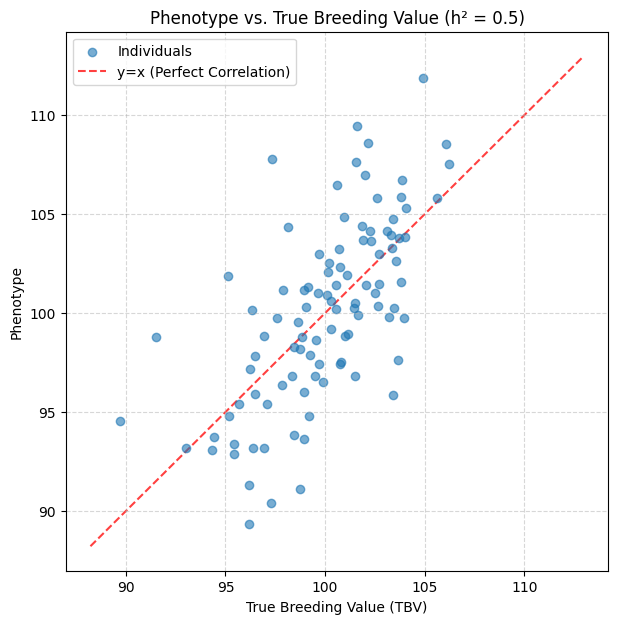


✅ Script finished.


In [1]:
import jax
import jax.numpy as jnp
import numpy as np # For converting arrays before plotting
import matplotlib.pyplot as plt # For plotting
from flax.struct import dataclass
from typing import List, Optional
from jax import lax, vmap
from functools import partial

# --- All data structures and functions from the previous example script ---
# (Population, Trait, SimConfig, compute_dosage, create_founders, add_trait)
# --- Plus our new `calculate_phenotypes` function ---

# (Paste all previous code here...)
@dataclass(frozen=True)
class Population:
    geno: jnp.ndarray
    meta: jnp.ndarray

@dataclass(frozen=True)
class Trait:
    qtl_chromosome: jnp.ndarray
    qtl_position: jnp.ndarray
    qtl_effects: jnp.ndarray
    intercept: jnp.ndarray

@dataclass(frozen=True)
class SimConfig:
    n_chr: int
    n_loci_per_chr: int
    ploidy: int
    genetic_map: jnp.ndarray
    traits: List[Trait]

def compute_dosage(geno: jnp.ndarray) -> jnp.ndarray:
    return jnp.sum(geno, axis=2, dtype=jnp.int8)

def calculate_tbv(dosage: jnp.ndarray, trait: Trait) -> jnp.ndarray:
    qtl_dosage = dosage[:, trait.qtl_chromosome, trait.qtl_position]
    tbv = jnp.dot(qtl_dosage, trait.qtl_effects) + trait.intercept
    return tbv

def create_founders(key: jax.random.PRNGKey, config: SimConfig, n_founders: int) -> Population:
    geno_key, meta_key = jax.random.split(key)
    geno = jax.random.randint(geno_key,
                              shape=(n_founders, config.n_chr, config.ploidy, config.n_loci_per_chr),
                              minval=0, maxval=2, dtype=jnp.int8)
    ids = jnp.arange(n_founders, dtype=jnp.int32)
    parent_ids = jnp.full((n_founders, 2), -1, dtype=jnp.int32)
    birth_gen = jnp.zeros((n_founders, 1), dtype=jnp.int32)
    meta = jnp.hstack([ids[:, None], parent_ids, birth_gen])
    return Population(geno=geno, meta=meta)

def add_trait(key: jax.random.PRNGKey, founder_pop: Population, config: SimConfig, n_qtl_per_chr: int, mean: jnp.ndarray, var: jnp.ndarray, cor_a: Optional[jnp.ndarray] = None) -> SimConfig:
    n_traits = mean.shape[0]
    if cor_a is None: cor_a = jnp.identity(n_traits)
    key, qtl_key, effect_key = jax.random.split(key, 3)
    n_total_qtl = n_qtl_per_chr * config.n_chr
    all_loci_indices = jnp.arange(config.n_chr * config.n_loci_per_chr)
    qtl_loc_flat = jax.random.choice(qtl_key, all_loci_indices, shape=(n_total_qtl,), replace=False)
    qtl_loc_flat = jnp.sort(qtl_loc_flat)
    qtl_chromosome = qtl_loc_flat // config.n_loci_per_chr
    qtl_position = qtl_loc_flat % config.n_loci_per_chr
    raw_effects = jax.random.normal(effect_key, (n_total_qtl, n_traits))
    cholesky_matrix = jnp.linalg.cholesky(cor_a)
    correlated_raw_effects = raw_effects @ cholesky_matrix.T
    temp_trait = Trait(
        qtl_chromosome=qtl_chromosome,
        qtl_position=qtl_position,
        qtl_effects=correlated_raw_effects,
        intercept=jnp.zeros(n_traits)
    )
    founder_dosage = compute_dosage(founder_pop.geno)
    initial_gvs = calculate_tbv(founder_dosage, temp_trait)
    initial_vars = jnp.var(initial_gvs, axis=0)
    initial_means = jnp.mean(initial_gvs, axis=0)
    scaling_factors = jnp.sqrt(var / (initial_vars + 1e-8))
    final_intercepts = mean - (initial_means * scaling_factors)
    final_add_eff = correlated_raw_effects * scaling_factors
    final_trait = Trait(
        qtl_chromosome=qtl_chromosome,
        qtl_position=qtl_position,
        qtl_effects=final_add_eff,
        intercept=final_intercepts
    )
    return config.replace(traits=[final_trait])


import jax
import jax.numpy as jnp

# We assume the data structures and functions from the previous steps are defined
# (Population, Trait, SimConfig, calculate_tbv)

def calculate_phenotypes(
    key: jax.random.PRNGKey,
    tbv: jnp.ndarray,
    h2: float,
    broad_sense: bool = False,
) -> jnp.ndarray:
    """
    Calculates phenotypes by adding environmental noise to achieve a target heritability.

    This is a pure, JIT-compatible function that operates on arrays. In a purely
    additive model, narrow-sense (h2) and broad-sense (H2) heritability are identical.
    The `broad_sense` flag is included for API consistency but has no effect here.

    Args:
        key: A JAX random key.
        tbv: An array of True Breeding Values, shape (n_ind, n_traits).
        h2: The target narrow-sense heritability.
        broad_sense: If True, uses total genetic variance for H2. (No effect in additive model).

    Returns:
        An array of phenotypes with the same shape as `tbv`.
    """
    # 1. Calculate the genetic variance from the True Breeding Values.
    # No masks are needed as per Rule #5. We operate on the entire input array.
    genetic_variance = jnp.var(tbv, axis=0)

    # 2. Calculate the required environmental variance using the heritability formula.
    # var_e = var_g * (1/h2 - 1)
    # Add a small epsilon to prevent division by zero if h2 is 0.
    var_e = genetic_variance * (1.0 / (h2 + 1e-8) - 1.0)
    var_e = jnp.maximum(0, var_e) # Ensure variance is non-negative

    # 3. Sample environmental noise from a normal distribution with the calculated variance.
    environmental_noise = jax.random.normal(key, tbv.shape) * jnp.sqrt(var_e)

    # 4. Phenotype is the sum of genetic value and environmental noise.
    phenotype = tbv + environmental_noise
    return phenotype


# --- Helper function to get cumulative genetic map positions ---
def _get_locus_positions(genetic_map: jnp.ndarray) -> jnp.ndarray:
    """Converts per-locus crossover probabilities to cumulative map positions in Morgans."""
    # The last position is the total map length.
    return jnp.cumsum(genetic_map, axis=-1)


## --- 1. Low-Level Kernel: Sample Chiasmata on a Single Chromosome ---

@partial(jax.jit, static_argnames=("max_crossovers",))
def _sample_chiasmata(
    key: jax.random.PRNGKey,
    map_length: jnp.ndarray, # Scalar array for total length in Morgans
    v_interference: float,
    max_crossovers: int = 20,
) -> jnp.ndarray:
    """
    Generates crossover positions along a single chromosome using a Gamma process.
    This simulates crossover interference.
    """
    # This function is already well-aligned with JAX principles.
    # It uses lax.scan for iteration and is a pure function.
    shape = v_interference
    scale = 1.0 / (2.0 * v_interference)

    def scan_body(carry, _):
        key, last_pos = carry
        key, subkey = jax.random.split(key)
        distance = jax.random.gamma(subkey, shape) * scale
        new_pos = last_pos + distance
        return (key, new_pos), new_pos

    key, initial_key = jax.random.split(key)
    initial_start_pos = jax.random.uniform(initial_key, minval=-1.0, maxval=0.0) # Start sampling before the chromosome
    init_carry = (key, initial_start_pos)

    _, crossover_positions = lax.scan(
        scan_body, init_carry, None, length=max_crossovers
    )

    valid_mask = (crossover_positions > 0) & (crossover_positions < map_length)
    return jnp.where(valid_mask, crossover_positions, jnp.inf)


## --- 2. Mid-Level Kernel: Create a Single Gamete for One Chromosome ---

@partial(jax.jit, static_argnames=("max_crossovers",))
def _create_gamete_for_chromosome(
    key: jax.random.PRNGKey,
    parental_haplotypes: jnp.ndarray, # Shape: (ploidy, n_loci)
    locus_positions: jnp.ndarray,     # Shape: (n_loci,) - cumulative map positions
    v_interference: float,
    max_crossovers: int,
) -> jnp.ndarray:
    """
    Creates a single recombinant gamete for one chromosome.
    """
    key, chiasma_key, hap_key = jax.random.split(key, 3)
    map_length = locus_positions[-1]

    # Sample crossover locations and sort them
    crossover_positions = _sample_chiasmata(
        chiasma_key, map_length, v_interference, max_crossovers
    )
    sorted_crossovers = jnp.sort(crossover_positions)

    # Count crossovers before each locus to determine which segment it's in
    locus_segments = jnp.searchsorted(sorted_crossovers, locus_positions, side="right")

    # Randomly choose which parental haplotype (0 or 1) starts the gamete
    start_hap = jax.random.choice(hap_key, jnp.array([0, 1], dtype=jnp.uint8))

    # Haplotype choice alternates at each crossover
    haplotype_choice = (start_hap + locus_segments) % 2

    # Select alleles from the chosen haplotype for each locus
    gamete_geno = jnp.where(
        haplotype_choice == 0, parental_haplotypes[0], parental_haplotypes[1]
    )
    return gamete_geno


## --- 3. High-Level Kernel: Create Offspring from a Single Parent Pair ---

@partial(jax.jit, static_argnames=("n_chr", "max_crossovers"))
def _cross_pair(
    key: jax.random.PRNGKey,
    mother_geno: jnp.ndarray, # Shape: (n_chr, ploidy, n_loci)
    father_geno: jnp.ndarray, # Shape: (n_chr, ploidy, n_loci)
    locus_positions: jnp.ndarray, # Shape: (n_chr, n_loci)
    n_chr: int,
    v_interference: float,
    max_crossovers: int,
) -> jnp.ndarray:
    """
    Creates a single diploid progeny's genotype from two parents.
    This function is vmapped across chromosomes for parallel execution.
    """
    key_mother, key_father = jax.random.split(key)

    # vmap the gamete creation kernel over the chromosome axis (axis 0)
    vmapped_gamete_creator = vmap(
        _create_gamete_for_chromosome,
        in_axes=(0, 0, 0, None, None), # Map over keys, geno, locus_positions
    )

    mother_gamete = vmapped_gamete_creator(
        jax.random.split(key_mother, n_chr),
        mother_geno,
        locus_positions,
        v_interference,
        max_crossovers,
    )
    father_gamete = vmapped_gamete_creator(
        jax.random.split(key_father, n_chr),
        father_geno,
        locus_positions,
        v_interference,
        max_crossovers,
    )

    # Stack the two gametes to form the new diploid genotype
    # The new ploidy axis is axis=1
    return jnp.stack([mother_gamete, father_gamete], axis=1)


## --- 4. Main Public API: Create a New Population of Offspring ---

@partial(jax.jit, static_argnames=('config', 'max_crossovers', 'v_interference'))
def create_offspring(
    key: jax.random.PRNGKey,
    parent_population: Population,
    pairings: jnp.ndarray, # Shape: (n_crosses, 2) -> indices of [mother, father]
    config: SimConfig,
    current_gen: int,
    max_crossovers: int = 20,
    v_interference: float = 2.5,
) -> Population:
    """
    Creates a new Population object of offspring from specified parent pairings.
    This is the main, fully vectorized function for reproduction.
    """
    n_crosses = pairings.shape[0]
    
    # --- FIX WAS HERE ---
    # Get static values from the static `config` object, not from dynamic array shapes.
    n_chr = config.n_chr
    n_loci = config.n_loci_per_chr
    
    # Get parent genotypes based on the pairings matrix
    mother_indices, father_indices = pairings[:, 0], pairings[:, 1]
    mothers_geno = parent_population.geno[mother_indices]
    fathers_geno = parent_population.geno[father_indices]
    
    # Get cumulative map positions
    locus_positions = _get_locus_positions(config.genetic_map)

    # vmap the single-pair cross function over the batch of parents
    vmapped_cross_creator = vmap(
        _cross_pair,
        in_axes=(0, 0, 0, None, None, None, None),
    )

    offspring_geno = vmapped_cross_creator(
        jax.random.split(key, n_crosses),
        mothers_geno,
        fathers_geno,
        locus_positions,
        n_chr, # This is now correctly passed as a static value
        v_interference,
        max_crossovers,
    )

    # Create new metadata for the offspring
    offspring_ids = jnp.arange(n_crosses, dtype=jnp.int32) # Simple local IDs for this batch
    mother_ids = parent_population.meta[mother_indices, 0]
    father_ids = parent_population.meta[father_indices, 0]
    birth_gen = jnp.full((n_crosses, 1), current_gen, dtype=jnp.int32)
    
    offspring_meta = jnp.stack([offspring_ids, mother_ids, father_ids], axis=1)
    offspring_meta = jnp.hstack([offspring_meta, birth_gen])

    return Population(geno=offspring_geno, meta=offspring_meta)


# --- Main Experiment Setup ---
if __name__ == '__main__':
    key = jax.random.PRNGKey(42)

    # Steps 1, 2, and 3 are the same as before
    print("🧬 Step 1: Defining Simulation Configuration...")
    config = SimConfig(n_chr=10, n_loci_per_chr=1000, ploidy=2,
                       genetic_map=jnp.full(shape=(10, 1000), fill_value=0.01 * 1e6 * 1e-8), traits=[])
    
    print("\n👥 Step 2: Creating Founder Population...")
    key, founder_key = jax.random.split(key)
    n_founders = 100
    founder_pop = create_founders(founder_key, config, n_founders)

    print("\n🌾 Step 3: Adding an Additive Trait...")
    key, trait_key = jax.random.split(key)
    target_mean = jnp.array([100.0])
    target_variance = jnp.array([10.0])
    final_config = add_trait(
        key=trait_key, founder_pop=founder_pop, config=config,
        n_qtl_per_chr=10, mean=target_mean, var=target_variance
    )

    # --- Step 4: Phenotype the Founder Population ---
    print("\n📈 Step 4: Calculating Phenotypes for Founders...")
    key, pheno_key = jax.random.split(key)
    h2 = 0.5
    
    # First, calculate the True Breeding Values (on the fly)
    founder_dosage = compute_dosage(founder_pop.geno)
    founder_tbv = calculate_tbv(founder_dosage, final_config.traits[0])

    # Now, use the TBVs to generate phenotypes
    founder_phenotypes = calculate_phenotypes(pheno_key, founder_tbv, h2=h2)
    
    print(f"   - Generated phenotypes with target h² = {h2}")
    print(f"   - Founder TBV      | Mean: {jnp.mean(founder_tbv):.2f}, Var: {jnp.var(founder_tbv):.2f}")
    print(f"   - Founder Phenotype| Mean: {jnp.mean(founder_phenotypes):.2f}, Var: {jnp.var(founder_phenotypes):.2f}")
    
    # --- Step 5: Plot TBV vs. Phenotype ---
    print("\n📊 Step 5: Plotting results...")
    
    # Move data from device to host CPU for plotting (Rule #8)
    tbv_np = np.array(founder_tbv)
    phenotypes_np = np.array(founder_phenotypes)
    
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(tbv_np, phenotypes_np, alpha=0.6, label='Individuals')
    
    # Add a y=x line for reference
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='y=x (Perfect Correlation)')
    
    ax.set_xlabel("True Breeding Value (TBV)")
    ax.set_ylabel("Phenotype")
    ax.set_title(f"Phenotype vs. True Breeding Value (h² = {h2})")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    
    print("\n✅ Script finished.")

In [19]:
import jax
import jax.numpy as jnp
import numpy as np
from flax.struct import dataclass
from typing import List, Optional
from jax import lax, vmap
from functools import partial

## --- 1. Core Data Structures (Refactored) ---

@dataclass(frozen=True)
class Population:
    geno: jnp.ndarray
    meta: jnp.ndarray

@dataclass(frozen=True)
class Trait:
    qtl_chromosome: jnp.ndarray
    qtl_position: jnp.ndarray
    qtl_effects: jnp.ndarray
    intercept: jnp.ndarray

# --- REFACTOR ---
# Split config into static (hashable) and dynamic (array) parts.
@dataclass(frozen=True)
class StaticConfig:
    """Static, hashable configuration values."""
    n_chr: int
    n_loci_per_chr: int
    ploidy: int

@dataclass(frozen=True)
class DynamicConfig:
    """Dynamic, array-based configuration values."""
    genetic_map: jnp.ndarray
    traits: List[Trait]

## --- 2. Pure Genetic Kernels (Unchanged) ---

def compute_dosage(geno: jnp.ndarray) -> jnp.ndarray:
    return jnp.sum(geno, axis=2, dtype=jnp.int8)

def calculate_tbv(dosage: jnp.ndarray, trait: Trait) -> jnp.ndarray:
    qtl_dosage = dosage[:, trait.qtl_chromosome, trait.qtl_position]
    tbv = jnp.dot(qtl_dosage, trait.qtl_effects) + trait.intercept
    return tbv

## --- 3. Host-Side Setup Functions (Updated Signatures) ---

def create_founders(key: jax.random.PRNGKey, s_config: StaticConfig, n_founders: int) -> Population:
    geno_key, meta_key = jax.random.split(key)
    geno = jax.random.randint(geno_key,
                              shape=(n_founders, s_config.n_chr, s_config.ploidy, s_config.n_loci_per_chr),
                              minval=0, maxval=2, dtype=jnp.int8)
    ids = jnp.arange(n_founders, dtype=jnp.int32)
    parent_ids = jnp.full((n_founders, 2), -1, dtype=jnp.int32)
    birth_gen = jnp.zeros((n_founders, 1), dtype=jnp.int32)
    meta = jnp.hstack([ids[:, None], parent_ids, birth_gen])
    return Population(geno=geno, meta=meta)

def add_trait(key: jax.random.PRNGKey, founder_pop: Population, s_config: StaticConfig, d_config: DynamicConfig, n_qtl_per_chr: int, mean: jnp.ndarray, var: jnp.ndarray) -> DynamicConfig:
    n_traits = mean.shape[0]
    key, qtl_key, effect_key = jax.random.split(key, 3)
    n_total_qtl = n_qtl_per_chr * s_config.n_chr
    all_loci_indices = jnp.arange(s_config.n_chr * s_config.n_loci_per_chr)
    qtl_loc_flat = jax.random.choice(qtl_key, all_loci_indices, shape=(n_total_qtl,), replace=False)
    qtl_loc_flat = jnp.sort(qtl_loc_flat)
    qtl_chromosome = qtl_loc_flat // s_config.n_loci_per_chr
    qtl_position = qtl_loc_flat % s_config.n_loci_per_chr
    raw_effects = jax.random.normal(effect_key, (n_total_qtl, n_traits))
    correlated_raw_effects = raw_effects @ jnp.linalg.cholesky(jnp.identity(n_traits))
    temp_trait = Trait(
        qtl_chromosome=qtl_chromosome,
        qtl_position=qtl_position,
        qtl_effects=correlated_raw_effects,
        intercept=jnp.zeros(n_traits)
    )
    founder_dosage = compute_dosage(founder_pop.geno)
    initial_gvs = calculate_tbv(founder_dosage, temp_trait)
    scaling_factors = jnp.sqrt(var / (jnp.var(initial_gvs, axis=0) + 1e-8))
    final_intercepts = mean - (jnp.mean(initial_gvs, axis=0) * scaling_factors)
    final_add_eff = correlated_raw_effects * scaling_factors
    final_trait = Trait(
        qtl_chromosome=qtl_chromosome,
        qtl_position=qtl_position,
        qtl_effects=final_add_eff,
        intercept=final_intercepts
    )
    return d_config.replace(traits=[final_trait])

## --- 4. Meiosis and Crossing Kernels (Updated Signatures) ---

def _get_locus_positions(genetic_map: jnp.ndarray) -> jnp.ndarray:
    return jnp.cumsum(genetic_map, axis=-1)

# No JIT on internal helpers
def _sample_chiasmata(key: jax.random.PRNGKey, map_length: jnp.ndarray, v_interference: float, max_crossovers: int) -> jnp.ndarray:
    shape, scale = v_interference, 1.0 / (2.0 * v_interference)
    def scan_body(carry, _):
        key, last_pos = carry; key, subkey = jax.random.split(key)
        new_pos = last_pos + jax.random.gamma(subkey, shape) * scale; return (key, new_pos), new_pos
    key, initial_key = jax.random.split(key); init_carry = (key, jax.random.uniform(initial_key, minval=-1.0, maxval=0.0))
    _, crossover_positions = lax.scan(scan_body, init_carry, None, length=max_crossovers)
    valid_mask = (crossover_positions > 0) & (crossover_positions < map_length)
    return jnp.where(valid_mask, crossover_positions, jnp.inf)

def _create_gamete_for_chromosome(key: jax.random.PRNGKey, parental_haplotypes: jnp.ndarray, locus_positions: jnp.ndarray, v_interference: float, max_crossovers: int) -> jnp.ndarray:
    key, chiasma_key, hap_key = jax.random.split(key, 3)
    sorted_crossovers = jnp.sort(_sample_chiasmata(chiasma_key, locus_positions[-1], v_interference, max_crossovers))
    locus_segments = jnp.searchsorted(sorted_crossovers, locus_positions, side="right")
    start_hap = jax.random.choice(hap_key, jnp.array([0, 1], dtype=jnp.uint8))
    haplotype_choice = (start_hap + locus_segments) % 2
    return jnp.where(haplotype_choice == 0, parental_haplotypes[0], parental_haplotypes[1])

def _cross_pair(key: jax.random.PRNGKey, mother_geno: jnp.ndarray, father_geno: jnp.ndarray, locus_positions: jnp.ndarray, n_chr: int, v_interference: float, max_crossovers: int) -> jnp.ndarray:
    key_mother, key_father = jax.random.split(key)
    vmapped_gamete_creator = vmap(_create_gamete_for_chromosome, in_axes=(0, 0, 0, None, None))
    mother_gamete = vmapped_gamete_creator(jax.random.split(key_mother, n_chr), mother_geno, locus_positions, v_interference, max_crossovers)
    father_gamete = vmapped_gamete_creator(jax.random.split(key_father, n_chr), father_geno, locus_positions, v_interference, max_crossovers)
    return jnp.stack([mother_gamete, father_gamete], axis=1)

# --- FINAL WORKING JIT DECORATOR ---
# `s_config` is now static, providing concrete values for control flow.
@partial(jax.jit, static_argnames=('s_config', 'current_gen', 'max_crossovers', 'v_interference'))
def create_offspring(key: jax.random.PRNGKey, parent_population: Population, pairings: jnp.ndarray, s_config: StaticConfig, d_config: DynamicConfig, current_gen: int, max_crossovers: int = 20, v_interference: float = 2.5) -> Population:
    n_crosses = pairings.shape[0]
    n_chr = s_config.n_chr
    mother_indices, father_indices = pairings[:, 0], pairings[:, 1]
    mothers_geno, fathers_geno = parent_population.geno[mother_indices], parent_population.geno[father_indices]
    locus_positions = _get_locus_positions(d_config.genetic_map)
    vmapped_cross_creator = vmap(_cross_pair, in_axes=(0, 0, 0, None, None, None, None))
    offspring_geno = vmapped_cross_creator(jax.random.split(key, n_crosses), mothers_geno, fathers_geno, locus_positions, n_chr, v_interference, max_crossovers)
    offspring_ids = jnp.arange(n_crosses, dtype=jnp.int32)
    mother_ids, father_ids = parent_population.meta[mother_indices, 0], parent_population.meta[father_indices, 0]
    birth_gen = jnp.full((n_crosses, 1), current_gen, dtype=jnp.int32)
    offspring_meta = jnp.stack([offspring_ids, mother_ids, father_ids], axis=1)
    offspring_meta = jnp.hstack([offspring_meta, birth_gen])
    return Population(geno=offspring_geno, meta=offspring_meta)

## --- 5. Main Experiment Script (Updated) ---
if __name__ == '__main__':
    key = jax.random.PRNGKey(42)

    # --- Step 1, 2, 3: Standard Setup with Refactored Config ---
    print("🧬 Step 1-3: Defining config, creating founders, and adding trait...")
    key, founder_key, trait_key = jax.random.split(key, 3)
    n_founders = 100
    
    s_config = StaticConfig(n_chr=10, n_loci_per_chr=1000, ploidy=2)
    d_config = DynamicConfig(
        genetic_map=jnp.full(shape=(s_config.n_chr, s_config.n_loci_per_chr), fill_value=0.01 * 1e6 * 1e-8),
        traits=[]
    )
    
    founder_pop = create_founders(founder_key, s_config, n_founders)
    
    final_d_config = add_trait(
        key=trait_key, founder_pop=founder_pop, s_config=s_config, d_config=d_config,
        n_qtl_per_chr=10, mean=jnp.array([100.0]), var=jnp.array([10.0])
    )
    print(f"   - Founder population created with {n_founders} individuals.")

    # --- Step 4: Create Offspring by Randomly Mating Founders ---
    print("\n🌿 Step 4: Creating Offspring Generation...")
    key, mate_key, cross_key = jax.random.split(key, 3)
    
    n_offspring = n_founders
    
    parent_indices = jnp.arange(n_founders)
    mothers = jax.random.choice(mate_key, parent_indices, shape=(n_offspring,))
    fathers = jax.random.choice(mate_key, parent_indices, shape=(n_offspring,))
    fathers = jnp.where(mothers == fathers, (fathers + 1) % n_founders, fathers)
    pairings = jnp.stack([mothers, fathers], axis=1)

    offspring_pop = create_offspring(
        key=cross_key,
        parent_population=founder_pop,
        pairings=pairings,
        s_config=s_config,
        d_config=final_d_config,
        current_gen=1
    )

    print(f"   - Successfully created {n_offspring} offspring.")
    print(f"   - Offspring genotype array shape: {offspring_pop.geno.shape}")

    # --- Step 5: Verify the Offspring ---
    print("\n🔎 Step 5: Verifying Offspring...")
    print("   - Offspring Meta (first 5 rows): [ID, Mother_ID, Father_ID, Birth_Gen]")
    print(np.array(offspring_pop.meta[:5]))
    
    founder_tbv = calculate_tbv(compute_dosage(founder_pop.geno), final_d_config.traits[0])
    offspring_tbv = calculate_tbv(compute_dosage(offspring_pop.geno), final_d_config.traits[0])
    print(f"\n   - Founder TBV Mean: {jnp.mean(founder_tbv):.2f}")
    print(f"   - Offspring TBV Mean: {jnp.mean(offspring_tbv):.2f}")

    print("\n✅ Script finished.")

🧬 Step 1-3: Defining config, creating founders, and adding trait...
   - Founder population created with 100 individuals.

🌿 Step 4: Creating Offspring Generation...
   - Successfully created 100 offspring.
   - Offspring genotype array shape: (100, 10, 2, 1000)

🔎 Step 5: Verifying Offspring...
   - Offspring Meta (first 5 rows): [ID, Mother_ID, Father_ID, Birth_Gen]
[[ 0 37 38  1]
 [ 1 89 90  1]
 [ 2 98 99  1]
 [ 3 43 44  1]
 [ 4 18 19  1]]

   - Founder TBV Mean: 100.00
   - Offspring TBV Mean: 99.72

✅ Script finished.


🧬 Step 1-3: Defining config, creating founders, and adding trait...
   - Founder population created with 100 individuals.

📈 Step 4: Calculating Phenotypes for Founders...
   - Founder Phenotype Mean: 100.06

🌿 Step 5: Selecting Top 20% and Creating Next Generation...
   - Selected 5 parents for mating.
   - Successfully created 100 offspring.

📊 Step 6: Analyzing Genetic Gain...
   - Offspring Phenotype Mean: 110.34


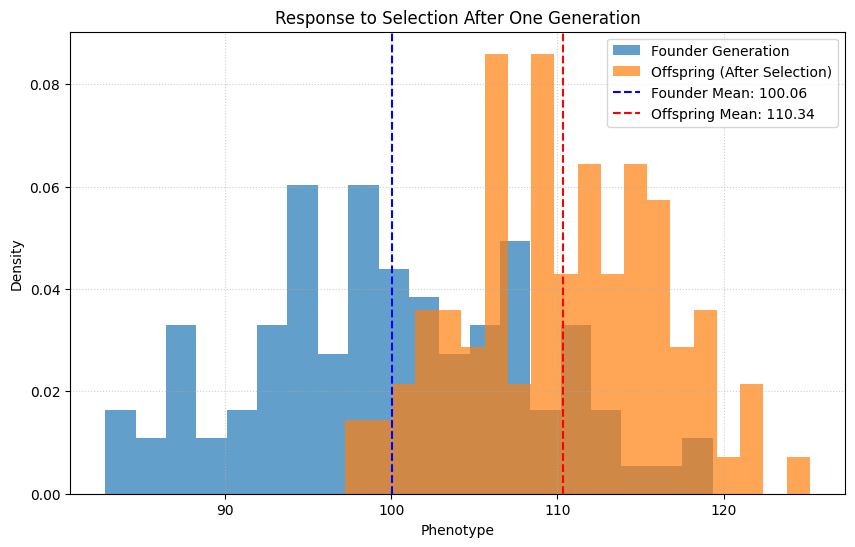


✅ Script finished.


In [6]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from flax.struct import dataclass
from typing import List, Optional
from jax import lax, vmap
from functools import partial

# --- (The entire ChewC codebase from the previous step is assumed to be here) ---
# All dataclasses (Population, Trait, StaticConfig, DynamicConfig)
# All kernels (compute_dosage, calculate_tbv, calculate_phenotypes)
# All setup functions (create_founders, add_trait)
# All meiosis functions (_get_locus_positions, _sample_chiasmata, etc., create_offspring)

@dataclass(frozen=True)
class Population:
    geno: jnp.ndarray
    meta: jnp.ndarray

@dataclass(frozen=True)
class Trait:
    qtl_chromosome: jnp.ndarray
    qtl_position: jnp.ndarray
    qtl_effects: jnp.ndarray
    intercept: jnp.ndarray

@dataclass(frozen=True)
class StaticConfig:
    n_chr: int
    n_loci_per_chr: int
    ploidy: int

@dataclass(frozen=True)
class DynamicConfig:
    genetic_map: jnp.ndarray
    traits: List[Trait]

def compute_dosage(geno: jnp.ndarray) -> jnp.ndarray:
    return jnp.sum(geno, axis=2, dtype=jnp.int8)

def calculate_tbv(dosage: jnp.ndarray, trait: Trait) -> jnp.ndarray:
    qtl_dosage = dosage[:, trait.qtl_chromosome, trait.qtl_position]
    return jnp.dot(qtl_dosage, trait.qtl_effects) + trait.intercept

def calculate_phenotypes(key: jax.random.PRNGKey, tbv: jnp.ndarray, h2: float) -> jnp.ndarray:
    genetic_variance = jnp.var(tbv, axis=0)
    var_e = genetic_variance * (1.0 / (h2 + 1e-8) - 1.0)
    var_e = jnp.maximum(0, var_e)
    environmental_noise = jax.random.normal(key, tbv.shape) * jnp.sqrt(var_e)
    return tbv + environmental_noise

def create_founders(key: jax.random.PRNGKey, s_config: StaticConfig, n_founders: int) -> Population:
    geno_key, _ = jax.random.split(key)
    geno = jax.random.randint(geno_key,
                              shape=(n_founders, s_config.n_chr, s_config.ploidy, s_config.n_loci_per_chr),
                              minval=0, maxval=2, dtype=jnp.int8)
    ids = jnp.arange(n_founders, dtype=jnp.int32)
    parent_ids = jnp.full((n_founders, 2), -1, dtype=jnp.int32)
    birth_gen = jnp.zeros((n_founders, 1), dtype=jnp.int32)
    meta = jnp.hstack([ids[:, None], parent_ids, birth_gen])
    return Population(geno=geno, meta=meta)

def add_trait(key: jax.random.PRNGKey, founder_pop: Population, s_config: StaticConfig, d_config: DynamicConfig, n_qtl_per_chr: int, mean: jnp.ndarray, var: jnp.ndarray) -> DynamicConfig:
    n_traits = mean.shape[0]
    key, qtl_key, effect_key = jax.random.split(key, 3)
    n_total_qtl = n_qtl_per_chr * s_config.n_chr
    all_loci_indices = jnp.arange(s_config.n_chr * s_config.n_loci_per_chr)
    qtl_loc_flat = jax.random.choice(qtl_key, all_loci_indices, shape=(n_total_qtl,), replace=False)
    qtl_loc_flat = jnp.sort(qtl_loc_flat)
    qtl_chromosome = qtl_loc_flat // s_config.n_loci_per_chr
    qtl_position = qtl_loc_flat % s_config.n_loci_per_chr
    raw_effects = jax.random.normal(effect_key, (n_total_qtl, n_traits))
    correlated_raw_effects = raw_effects @ jnp.linalg.cholesky(jnp.identity(n_traits))
    temp_trait = Trait(
        qtl_chromosome=qtl_chromosome,
        qtl_position=qtl_position,
        qtl_effects=correlated_raw_effects,
        intercept=jnp.zeros(n_traits)
    )
    founder_dosage = compute_dosage(founder_pop.geno)
    initial_gvs = calculate_tbv(founder_dosage, temp_trait)
    scaling_factors = jnp.sqrt(var / (jnp.var(initial_gvs, axis=0) + 1e-8))
    final_intercepts = mean - (jnp.mean(initial_gvs, axis=0) * scaling_factors)
    final_add_eff = correlated_raw_effects * scaling_factors
    final_trait = Trait(
        qtl_chromosome=qtl_chromosome,
        qtl_position=qtl_position,
        qtl_effects=final_add_eff,
        intercept=final_intercepts
    )
    return d_config.replace(traits=[final_trait])

def _get_locus_positions(genetic_map: jnp.ndarray) -> jnp.ndarray:
    return jnp.cumsum(genetic_map, axis=-1)

def _sample_chiasmata(key: jax.random.PRNGKey, map_length: jnp.ndarray, v_interference: float, max_crossovers: int) -> jnp.ndarray:
    shape, scale = v_interference, 1.0 / (2.0 * v_interference)
    def scan_body(carry, _):
        key, last_pos = carry; key, subkey = jax.random.split(key)
        new_pos = last_pos + jax.random.gamma(subkey, shape) * scale; return (key, new_pos), new_pos
    key, initial_key = jax.random.split(key); init_carry = (key, jax.random.uniform(initial_key, minval=-1.0, maxval=0.0))
    _, crossover_positions = lax.scan(scan_body, init_carry, None, length=max_crossovers)
    valid_mask = (crossover_positions > 0) & (crossover_positions < map_length)
    return jnp.where(valid_mask, crossover_positions, jnp.inf)

def _create_gamete_for_chromosome(key: jax.random.PRNGKey, parental_haplotypes: jnp.ndarray, locus_positions: jnp.ndarray, v_interference: float, max_crossovers: int) -> jnp.ndarray:
    key, chiasma_key, hap_key = jax.random.split(key, 3)
    sorted_crossovers = jnp.sort(_sample_chiasmata(chiasma_key, locus_positions[-1], v_interference, max_crossovers))
    locus_segments = jnp.searchsorted(sorted_crossovers, locus_positions, side="right")
    start_hap = jax.random.choice(hap_key, jnp.array([0, 1], dtype=jnp.uint8))
    haplotype_choice = (start_hap + locus_segments) % 2
    return jnp.where(haplotype_choice == 0, parental_haplotypes[0], parental_haplotypes[1])

def _cross_pair(key: jax.random.PRNGKey, mother_geno: jnp.ndarray, father_geno: jnp.ndarray, locus_positions: jnp.ndarray, n_chr: int, v_interference: float, max_crossovers: int) -> jnp.ndarray:
    key_mother, key_father = jax.random.split(key)
    vmapped_gamete_creator = vmap(_create_gamete_for_chromosome, in_axes=(0, 0, 0, None, None))
    mother_gamete = vmapped_gamete_creator(jax.random.split(key_mother, n_chr), mother_geno, locus_positions, v_interference, max_crossovers)
    father_gamete = vmapped_gamete_creator(jax.random.split(key_father, n_chr), father_geno, locus_positions, v_interference, max_crossovers)
    return jnp.stack([mother_gamete, father_gamete], axis=1)

@partial(jax.jit, static_argnames=('s_config', 'current_gen', 'max_crossovers', 'v_interference'))
def create_offspring(key: jax.random.PRNGKey, parent_population: Population, pairings: jnp.ndarray, s_config: StaticConfig, d_config: DynamicConfig, current_gen: int, max_crossovers: int = 20, v_interference: float = 2.5) -> Population:
    n_crosses = pairings.shape[0]
    n_chr = s_config.n_chr
    mother_indices, father_indices = pairings[:, 0], pairings[:, 1]
    mothers_geno, fathers_geno = parent_population.geno[mother_indices], parent_population.geno[father_indices]
    locus_positions = _get_locus_positions(d_config.genetic_map)
    vmapped_cross_creator = vmap(_cross_pair, in_axes=(0, 0, 0, None, None, None, None))
    offspring_geno = vmapped_cross_creator(jax.random.split(key, n_crosses), mothers_geno, fathers_geno, locus_positions, n_chr, v_interference, max_crossovers)
    offspring_ids = jnp.arange(n_crosses, dtype=jnp.int32)
    mother_ids, father_ids = parent_population.meta[mother_indices, 0], parent_population.meta[father_indices, 0]
    birth_gen = jnp.full((n_crosses, 1), current_gen, dtype=jnp.int32)
    offspring_meta = jnp.stack([offspring_ids, mother_ids, father_ids], axis=1)
    offspring_meta = jnp.hstack([offspring_meta, birth_gen])
    return Population(geno=offspring_geno, meta=offspring_meta)


if __name__ == '__main__':
    key = jax.random.PRNGKey(42)

    # --- Step 1-3: Standard Setup ---
    print("🧬 Step 1-3: Defining config, creating founders, and adding trait...")
    key, founder_key, trait_key = jax.random.split(key, 3)
    n_founders = 100
    
    s_config = StaticConfig(n_chr=10, n_loci_per_chr=1000, ploidy=2)
    d_config = DynamicConfig(
        genetic_map=jnp.full(shape=(s_config.n_chr, s_config.n_loci_per_chr), fill_value=0.01 * 1e6 * 1e-8),
        traits=[]
    )
    founder_pop = create_founders(founder_key, s_config, n_founders)
    final_d_config = add_trait(
        key=trait_key, founder_pop=founder_pop, s_config=s_config, d_config=d_config,
        n_qtl_per_chr=10, mean=jnp.array([100.0]), var=jnp.array([50.0])
    )
    print(f"   - Founder population created with {n_founders} individuals.")

    # --- Step 4: Phenotype the Founder Population ---
    print("\n📈 Step 4: Calculating Phenotypes for Founders...")
    key, pheno_key = jax.random.split(key)
    h2 = 0.8
    
    founder_dosage = compute_dosage(founder_pop.geno)
    founder_tbv = calculate_tbv(founder_dosage, final_d_config.traits[0])
    founder_phenotypes = calculate_phenotypes(pheno_key, founder_tbv, h2=h2)
    print(f"   - Founder Phenotype Mean: {jnp.mean(founder_phenotypes):.2f}")

    # --- Step 5: Selection and Mating ---
    print("\n🌿 Step 5: Selecting Top 20% and Creating Next Generation...")
    key, select_key, mate_key, cross_key = jax.random.split(key, 4)
    
    # 5a. Sort founders by phenotype and get the indices of the top 20%
    n_select = int(n_founders * 0.05)
    # Note: argsort sorts in ascending order, so we take from the end of the list
    sorted_indices = jnp.argsort(founder_phenotypes.flatten())
    top_parent_indices = sorted_indices[-n_select:]
    
    # 5b. Create a new, smaller Population object just for the selected parents
    # This keeps our state lean for the next step.
    selected_parents_pop = jax.tree.map(lambda x: x[top_parent_indices], founder_pop)
    print(f"   - Selected {n_select} parents for mating.")
    
    # 5c. Randomly mate the selected parents to create 100 offspring
    n_offspring = 100
    parent_pool_indices = jnp.arange(n_select)
    mothers = jax.random.choice(mate_key, parent_pool_indices, shape=(n_offspring,))
    fathers = jax.random.choice(mate_key, parent_pool_indices, shape=(n_offspring,))
    fathers = jnp.where(mothers == fathers, (fathers + 1) % n_select, fathers)
    pairings = jnp.stack([mothers, fathers], axis=1)

    offspring_pop = create_offspring(
        key=cross_key,
        parent_population=selected_parents_pop,
        pairings=pairings,
        s_config=s_config,
        d_config=final_d_config,
        current_gen=1
    )
    print(f"   - Successfully created {n_offspring} offspring.")

    # --- Step 6: Analyze and Compare Generations ---
    print("\n📊 Step 6: Analyzing Genetic Gain...")
    key, offspring_pheno_key = jax.random.split(key)

    # 6a. Calculate phenotypes for the new offspring
    offspring_dosage = compute_dosage(offspring_pop.geno)
    offspring_tbv = calculate_tbv(offspring_dosage, final_d_config.traits[0])
    offspring_phenotypes = calculate_phenotypes(offspring_pheno_key, offspring_tbv, h2=h2)
    
    print(f"   - Offspring Phenotype Mean: {jnp.mean(offspring_phenotypes):.2f}")
    
    # 6b. Plot overlapping histograms
    plt.figure(figsize=(10, 6))
    plt.hist(np.array(founder_phenotypes), bins=20, alpha=0.7, label='Founder Generation', density=True)
    plt.hist(np.array(offspring_phenotypes), bins=20, alpha=0.7, label='Offspring (After Selection)', density=True)
    plt.axvline(jnp.mean(founder_phenotypes), color='blue', linestyle='--', label=f'Founder Mean: {jnp.mean(founder_phenotypes):.2f}')
    plt.axvline(jnp.mean(offspring_phenotypes), color='red', linestyle='--', label=f'Offspring Mean: {jnp.mean(offspring_phenotypes):.2f}')
    plt.title('Response to Selection After One Generation')
    plt.xlabel('Phenotype')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

    print("\n✅ Script finished.")

In [9]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from flax.struct import dataclass
from typing import List, Optional
from jax import lax, vmap
from functools import partial

## --- 1. CORE DATA STRUCTURES ---
@dataclass(frozen=True)
class Population:
    geno: jnp.ndarray
    meta: jnp.ndarray

@dataclass(frozen=True)
class Trait:
    qtl_chromosome: jnp.ndarray
    qtl_position: jnp.ndarray
    qtl_effects: jnp.ndarray
    intercept: jnp.ndarray

@dataclass(frozen=True)
class StaticConfig:
    n_chr: int
    n_loci_per_chr: int
    ploidy: int
    n_select: int
    n_offspring: int

@dataclass(frozen=True)
class DynamicConfig:
    genetic_map: jnp.ndarray
    traits: List[Trait]

## --- 2. HOST-SIDE SETUP FUNCTIONS ---
def create_founders(key: jax.random.PRNGKey, s_config: StaticConfig, n_founders: int) -> Population:
    geno_key, _ = jax.random.split(key)
    geno = jax.random.randint(geno_key,
                              shape=(n_founders, s_config.n_chr, s_config.ploidy, s_config.n_loci_per_chr),
                              minval=0, maxval=2, dtype=jnp.int8)
    ids = jnp.arange(n_founders, dtype=jnp.int32)
    parent_ids = jnp.full((n_founders, 2), -1, dtype=jnp.int32)
    birth_gen = jnp.zeros((n_founders, 1), dtype=jnp.int32)
    meta = jnp.hstack([ids[:, None], parent_ids, birth_gen])
    return Population(geno=geno, meta=meta)

def add_trait(key: jax.random.PRNGKey, founder_pop: Population, s_config: StaticConfig, d_config: DynamicConfig, n_qtl_per_chr: int, mean: jnp.ndarray, var: jnp.ndarray) -> DynamicConfig:
    n_traits = mean.shape[0]
    key, qtl_key, effect_key = jax.random.split(key, 3)
    n_total_qtl = n_qtl_per_chr * s_config.n_chr
    all_loci_indices = jnp.arange(s_config.n_chr * s_config.n_loci_per_chr)
    qtl_loc_flat = jax.random.choice(qtl_key, all_loci_indices, shape=(n_total_qtl,), replace=False)
    qtl_loc_flat = jnp.sort(qtl_loc_flat)
    qtl_chromosome = qtl_loc_flat // s_config.n_loci_per_chr
    qtl_position = qtl_loc_flat % s_config.n_loci_per_chr
    raw_effects = jax.random.normal(effect_key, (n_total_qtl, n_traits))
    correlated_raw_effects = raw_effects @ jnp.linalg.cholesky(jnp.identity(n_traits))
    temp_trait = Trait(qtl_chromosome, qtl_position, correlated_raw_effects, jnp.zeros(n_traits))
    founder_dosage = jnp.sum(founder_pop.geno, axis=2, dtype=jnp.int8)
    initial_gvs = jnp.dot(founder_dosage[:, temp_trait.qtl_chromosome, temp_trait.qtl_position], temp_trait.qtl_effects)
    scaling_factors = jnp.sqrt(var / (jnp.var(initial_gvs, axis=0) + 1e-8))
    final_intercepts = mean - (jnp.mean(initial_gvs, axis=0) * scaling_factors)
    final_add_eff = correlated_raw_effects * scaling_factors
    final_trait = Trait(qtl_chromosome, qtl_position, final_add_eff, final_intercepts)
    return d_config.replace(traits=[final_trait])

## --- 3. MEIOSIS AND SIMULATION KERNELS ---
_get_locus_positions = jax.jit(lambda genetic_map: jnp.cumsum(genetic_map, axis=-1))

def _sample_chiasmata(key: jax.random.PRNGKey, map_length: jnp.ndarray, v_interference: float, max_crossovers: int) -> jnp.ndarray:
    shape, scale = v_interference, 1.0 / (2.0 * v_interference)
    def scan_body(carry, _):
        key, last_pos = carry; key, subkey = jax.random.split(key)
        new_pos = last_pos + jax.random.gamma(subkey, shape) * scale; return (key, new_pos), new_pos
    key, initial_key = jax.random.split(key); init_carry = (key, jax.random.uniform(initial_key, minval=-1.0, maxval=0.0))
    _, crossover_positions = lax.scan(scan_body, init_carry, None, length=max_crossovers)
    return jnp.where((crossover_positions > 0) & (crossover_positions < map_length), crossover_positions, jnp.inf)

def _create_gamete_for_chromosome(key: jax.random.PRNGKey, parental_haplotypes: jnp.ndarray, locus_positions: jnp.ndarray, v_interference: float, max_crossovers: int) -> jnp.ndarray:
    key, chiasma_key, hap_key = jax.random.split(key, 3)
    sorted_crossovers = jnp.sort(_sample_chiasmata(chiasma_key, locus_positions[-1], v_interference, max_crossovers))
    locus_segments = jnp.searchsorted(sorted_crossovers, locus_positions, side="right")
    start_hap = jax.random.choice(hap_key, jnp.array([0, 1], dtype=jnp.uint8))
    haplotype_choice = (start_hap + locus_segments) % 2
    return jnp.where(haplotype_choice == 0, parental_haplotypes[0], parental_haplotypes[1])

def _cross_pair(key: jax.random.PRNGKey, mother_geno: jnp.ndarray, father_geno: jnp.ndarray, locus_positions: jnp.ndarray, n_chr: int, v_interference: float, max_crossovers: int) -> jnp.ndarray:
    key_mother, key_father = jax.random.split(key)
    vmapped_gamete_creator = vmap(_create_gamete_for_chromosome, in_axes=(0, 0, 0, None, None))
    mother_gamete = vmapped_gamete_creator(jax.random.split(key_mother, n_chr), mother_geno, locus_positions, v_interference, max_crossovers)
    father_gamete = vmapped_gamete_creator(jax.random.split(key_father, n_chr), father_geno, locus_positions, v_interference, max_crossovers)
    return jnp.stack([mother_gamete, father_gamete], axis=1)

@partial(jax.jit, static_argnames=('s_config', 'current_gen', 'max_crossovers', 'v_interference'))
def create_offspring(key: jax.random.PRNGKey, parent_population: Population, pairings: jnp.ndarray, s_config: StaticConfig, d_config: DynamicConfig, current_gen: int, max_crossovers: int = 20, v_interference: float = 2.5) -> Population:
    n_crosses, n_chr = pairings.shape[0], s_config.n_chr
    mother_indices, father_indices = pairings[:, 0], pairings[:, 1]
    mothers_geno, fathers_geno = parent_population.geno[mother_indices], parent_population.geno[father_indices]
    locus_positions = _get_locus_positions(d_config.genetic_map)
    offspring_geno = vmap(_cross_pair, in_axes=(0, 0, 0, None, None, None, None))(
        jax.random.split(key, n_crosses), mothers_geno, fathers_geno, locus_positions, n_chr, v_interference, max_crossovers)
    offspring_ids = jnp.arange(n_crosses, dtype=jnp.int32)
    mother_ids, father_ids = parent_population.meta[mother_indices, 0], parent_population.meta[father_indices, 0]
    birth_gen = jnp.full((n_crosses, 1), current_gen, dtype=jnp.int32)
    offspring_meta = jnp.hstack([offspring_ids[:, None], jnp.stack([mother_ids, father_ids], axis=1), birth_gen])
    return Population(geno=offspring_geno, meta=offspring_meta)

def generation_step(carry, gen_idx: int, s_config: StaticConfig, d_config: DynamicConfig, h2: float):
    current_pop, key = carry
    key, pheno_key, mate_key, cross_key = jax.random.split(key, 4)
    dosage = compute_dosage(current_pop.geno)
    tbv = calculate_tbv(dosage, d_config.traits[0])
    phenotypes = calculate_phenotypes(pheno_key, tbv, h2)
    sorted_indices = jnp.argsort(phenotypes.flatten())
    top_parent_indices = sorted_indices[-s_config.n_select:]
    selected_parents_pop = jax.tree.map(lambda x: x[top_parent_indices], current_pop)
    parent_pool_indices = jnp.arange(s_config.n_select)
    mothers = jax.random.choice(mate_key, parent_pool_indices, shape=(s_config.n_offspring,))
    fathers = jax.random.choice(mate_key, parent_pool_indices, shape=(s_config.n_offspring,))
    fathers = jnp.where(mothers == fathers, (fathers + 1) % s_config.n_select, fathers)
    pairings = jnp.stack([mothers, fathers], axis=1)
    offspring_pop = create_offspring(cross_key, selected_parents_pop, pairings, s_config, d_config, current_gen=gen_idx + 1)
    new_carry = (offspring_pop, key)
    analytics = {'mean_tbv': jnp.mean(tbv)}
    return new_carry, analytics

@partial(jax.jit, static_argnames=('s_config', 'n_cycles', 'h2'))
def run_simulation(initial_pop: Population, initial_key: jax.random.PRNGKey, s_config: StaticConfig, d_config: DynamicConfig, n_cycles: int, h2: float):
    scan_body = partial(generation_step, s_config=s_config, d_config=d_config, h2=h2)
    _, history = lax.scan(scan_body, (initial_pop, initial_key), jnp.arange(n_cycles))
    return history

## --- 4. MAIN EXPERIMENT SCRIPT ---
if __name__ == '__main__':
    print("🧬 Setting up initial population and configuration...")
    master_key = jax.random.PRNGKey(42)
    n_founders, n_replicates, n_cycles = 100, 5, 10
    
    s_config = StaticConfig(n_chr=10, n_loci_per_chr=100, ploidy=2, n_select=20, n_offspring=100)
    d_config = DynamicConfig(genetic_map=jnp.full((s_config.n_chr, s_config.n_loci_per_chr), 0.01), traits=[])
    
    founder_pop = create_founders(master_key, s_config, n_founders)
    final_d_config = add_trait(master_key, founder_pop, s_config, d_config,
                             n_qtl_per_chr=10, mean=jnp.array([100.0]), var=jnp.array([10.0]))
    
    initial_tbv_mean = jnp.mean(calculate_tbv(compute_dosage(founder_pop.geno), final_d_config.traits[0]))
    print(f"   - Founder population created with Mean TBV: {initial_tbv_mean:.2f}")

    print(f"\n🚀 Preparing & running {n_replicates} replicates in parallel for {n_cycles} cycles each...")
    replicate_keys = jax.random.split(master_key, n_replicates)
    
    # --- FIX WAS HERE ---
    # Create a partial function with the static arguments (n_cycles, h2) baked in.
    sim_partial = partial(run_simulation, n_cycles=n_cycles, h2=0.3)
    # vmap now only sees the arguments that need to be mapped/broadcast.
    vmapped_simulation = vmap(sim_partial, in_axes=(None, 0, None, None))
    
    # The call now only needs the positional arguments that `in_axes` corresponds to.
    history = vmapped_simulation(founder_pop, replicate_keys, s_config, final_d_config)
    
    print("   - Simulation complete.")
    print("\n🔎 Analyzing results...")
    
    final_tbvs = history['mean_tbv'][:, -1]
    print("   - Mean TBV of final generation for each replicate:")
    for i in range(n_replicates):
        print(f"     - Replicate {i+1}: Initial TBV = {initial_tbv_mean:.2f} -> Final TBV = {final_tbvs[i]:.2f}")
    
    print(f"\n   - Average Final TBV across all replicates: {jnp.mean(final_tbvs):.2f}")

    plt.figure(figsize=(10, 6))
    for i in range(n_replicates):
        plt.plot(history['mean_tbv'][i], marker='o', linestyle='--', label=f'Replicate {i+1}')
    plt.axhline(initial_tbv_mean, color='black', linestyle=':', label='Founder Mean TBV')
    plt.title(f'Genetic Gain Across {n_replicates} Replicates')
    plt.xlabel('Cycle of Selection'); plt.ylabel('Mean True Breeding Value (TBV)')
    plt.legend(); plt.grid(True, alpha=0.5); plt.show()

    print("\n✅ Script finished successfully.")

🧬 Setting up initial population and configuration...
   - Founder population created with Mean TBV: 100.00

🚀 Preparing & running 5 replicates in parallel for 10 cycles each...


ValueError: Non-hashable static arguments are not supported. An error occurred while trying to hash an object of type <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>, Traced<int32[]>with<DynamicJaxprTrace>. The error was:
TypeError: unhashable type: 'DynamicJaxprTracer'


🧬 Setting up initial population and configuration...
   - Founder population created with Mean TBV: 100.00

🚀 Preparing & running 5 replicates in parallel for 10 cycles each...
   - Simulation complete.

🔎 Analyzing results...
   - Mean TBV of final generation for each replicate:
     - Replicate 1: Initial TBV = 100.00 -> Final TBV = 115.03
     - Replicate 2: Initial TBV = 100.00 -> Final TBV = 116.69
     - Replicate 3: Initial TBV = 100.00 -> Final TBV = 116.07
     - Replicate 4: Initial TBV = 100.00 -> Final TBV = 119.07
     - Replicate 5: Initial TBV = 100.00 -> Final TBV = 117.21

   - Average Final TBV across all replicates: 116.81


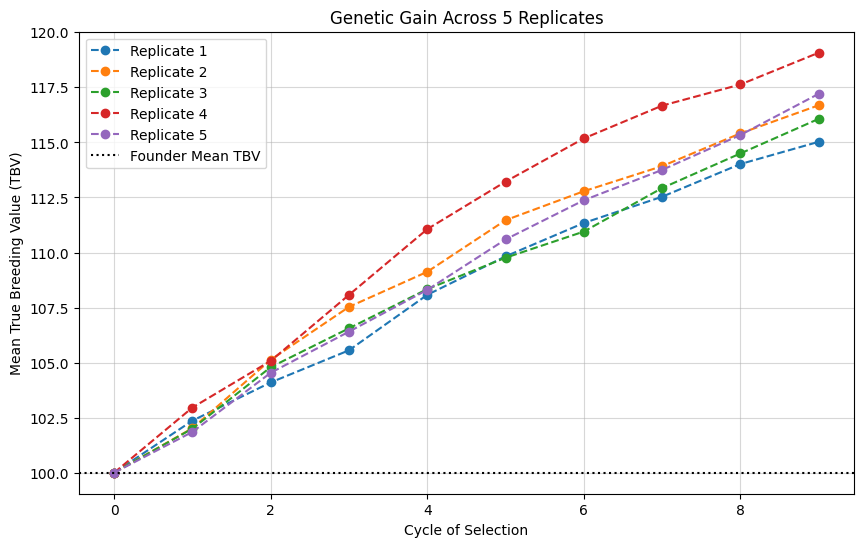


✅ Script finished successfully.


In [15]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from flax.struct import dataclass
from typing import List, Optional
from jax import lax, vmap
from functools import partial

## --- 1. CORE DATA STRUCTURES ---
@dataclass(frozen=True)
class Population:
    geno: jnp.ndarray; meta: jnp.ndarray
@dataclass(frozen=True)
class Trait:
    qtl_chromosome: jnp.ndarray; qtl_position: jnp.ndarray; qtl_effects: jnp.ndarray; intercept: jnp.ndarray
@dataclass(frozen=True)
class StaticConfig:
    n_chr: int; n_loci_per_chr: int; ploidy: int; n_select: int; n_offspring: int
@dataclass(frozen=True)
class DynamicConfig:
    genetic_map: jnp.ndarray; traits: List[Trait]

## --- 2. HOST-SIDE SETUP FUNCTIONS ---
def create_founders(key: jax.random.PRNGKey, s_config: StaticConfig, n_founders: int) -> Population:
    geno = jax.random.randint(key, (n_founders, s_config.n_chr, s_config.ploidy, s_config.n_loci_per_chr), 0, 2, dtype=jnp.int8)
    ids = jnp.arange(n_founders, dtype=jnp.int32)[:, None]
    parent_ids = jnp.full((n_founders, 2), -1, dtype=jnp.int32)
    birth_gen = jnp.zeros((n_founders, 1), dtype=jnp.int32)
    return Population(geno=geno, meta=jnp.hstack([ids, parent_ids, birth_gen]))

def add_trait(key: jax.random.PRNGKey, founder_pop: Population, s_config: StaticConfig, d_config: DynamicConfig, n_qtl_per_chr: int, mean: jnp.ndarray, var: jnp.ndarray) -> DynamicConfig:
    key, qtl_key, effect_key = jax.random.split(key, 3)
    n_total_qtl = n_qtl_per_chr * s_config.n_chr
    all_loci_indices = jnp.arange(s_config.n_chr * s_config.n_loci_per_chr)
    qtl_loc_flat = jax.random.choice(qtl_key, all_loci_indices, (n_total_qtl,), replace=False)
    qtl_chromosome, qtl_position = jnp.divmod(jnp.sort(qtl_loc_flat), s_config.n_loci_per_chr)
    raw_effects = jax.random.normal(effect_key, (n_total_qtl, mean.shape[0]))
    correlated_raw_effects = raw_effects @ jnp.linalg.cholesky(jnp.identity(mean.shape[0]))
    temp_trait = Trait(qtl_chromosome, qtl_position, correlated_raw_effects, jnp.zeros_like(mean))
    founder_dosage = jnp.sum(founder_pop.geno, axis=2, dtype=jnp.int8)
    initial_gvs = jnp.dot(founder_dosage[:, qtl_chromosome, qtl_position], correlated_raw_effects)
    scaling_factors = jnp.sqrt(var / (jnp.var(initial_gvs, axis=0) + 1e-8))
    final_intercepts = mean - (jnp.mean(initial_gvs, axis=0) * scaling_factors)
    final_add_eff = correlated_raw_effects * scaling_factors
    final_trait = Trait(qtl_chromosome, qtl_position, final_add_eff, final_intercepts)
    return d_config.replace(traits=[final_trait])

## --- 3. MEIOSIS AND SIMULATION KERNELS ---
_get_locus_positions = jax.jit(lambda genetic_map: jnp.cumsum(genetic_map, axis=-1))

def _sample_chiasmata(key: jax.random.PRNGKey, map_length: jnp.ndarray, v_interference: float, max_crossovers: int) -> jnp.ndarray:
    shape, scale = v_interference, 1.0 / (2.0 * v_interference)
    def scan_body(carry, _):
        key, last_pos = carry; key, subkey = jax.random.split(key)
        new_pos = last_pos + jax.random.gamma(subkey, shape) * scale; return (key, new_pos), new_pos
    key, initial_key = jax.random.split(key); init_carry = (key, jax.random.uniform(initial_key, minval=-1.0, maxval=0.0))
    _, crossover_positions = lax.scan(scan_body, init_carry, None, length=max_crossovers)
    return jnp.where((crossover_positions > 0) & (crossover_positions < map_length), crossover_positions, jnp.inf)

def _create_gamete_for_chromosome(key: jax.random.PRNGKey, parental_haplotypes: jnp.ndarray, locus_positions: jnp.ndarray, v_interference: float, max_crossovers: int) -> jnp.ndarray:
    key, chiasma_key, hap_key = jax.random.split(key, 3)
    sorted_crossovers = jnp.sort(_sample_chiasmata(chiasma_key, locus_positions[-1], v_interference, max_crossovers))
    locus_segments = jnp.searchsorted(sorted_crossovers, locus_positions, side="right")
    start_hap = jax.random.choice(hap_key, jnp.array([0, 1], dtype=jnp.uint8))
    haplotype_choice = (start_hap + locus_segments) % 2
    return jnp.where(haplotype_choice == 0, parental_haplotypes[0], parental_haplotypes[1])

def _cross_pair(key: jax.random.PRNGKey, mother_geno: jnp.ndarray, father_geno: jnp.ndarray, locus_positions: jnp.ndarray, n_chr: int, v_interference: float, max_crossovers: int) -> jnp.ndarray:
    key_mother, key_father = jax.random.split(key)
    vmapped_gamete_creator = vmap(_create_gamete_for_chromosome, in_axes=(0, 0, 0, None, None))
    mother_gamete = vmapped_gamete_creator(jax.random.split(key_mother, n_chr), mother_geno, locus_positions, v_interference, max_crossovers)
    father_gamete = vmapped_gamete_creator(jax.random.split(key_father, n_chr), father_geno, locus_positions, v_interference, max_crossovers)
    return jnp.stack([mother_gamete, father_gamete], axis=1)

# --- FIX WAS HERE: Removed the nested @jit from this helper function ---
def create_offspring(key: jax.random.PRNGKey, parent_population: Population, pairings: jnp.ndarray, s_config: StaticConfig, d_config: DynamicConfig, current_gen: int, max_crossovers: int = 20, v_interference: float = 2.5) -> Population:
    n_crosses, n_chr = pairings.shape[0], s_config.n_chr
    mother_indices, father_indices = pairings[:, 0], pairings[:, 1]
    mothers_geno, fathers_geno = parent_population.geno[mother_indices], parent_population.geno[father_indices]
    locus_positions = _get_locus_positions(d_config.genetic_map)
    offspring_geno = vmap(_cross_pair, in_axes=(0, 0, 0, None, None, None, None))(
        jax.random.split(key, n_crosses), mothers_geno, fathers_geno, locus_positions, n_chr, v_interference, max_crossovers)
    offspring_ids = jnp.arange(n_crosses, dtype=jnp.int32)[:, None]
    mother_ids, father_ids = parent_population.meta[mother_indices, 0], parent_population.meta[father_indices, 0]
    birth_gen = jnp.full((n_crosses, 1), current_gen, dtype=jnp.int32)
    return Population(geno=offspring_geno, meta=jnp.hstack([offspring_ids, jnp.stack([mother_ids, father_ids], axis=1), birth_gen]))

def generation_step(carry, gen_idx: int, s_config: StaticConfig, h2: float):
    current_pop, key, d_config = carry
    key, pheno_key, mate_key, cross_key = jax.random.split(key, 4)
    dosage = jnp.sum(current_pop.geno, axis=2, dtype=jnp.int8)
    trait = d_config.traits[0]
    tbv = jnp.dot(dosage[:, trait.qtl_chromosome, trait.qtl_position], trait.qtl_effects) + trait.intercept
    genetic_variance = jnp.var(tbv, axis=0)
    var_e = genetic_variance * (1.0 / (h2 + 1e-8) - 1.0)
    phenotypes = tbv + jax.random.normal(pheno_key, tbv.shape) * jnp.sqrt(jnp.maximum(0, var_e))
    top_parent_indices = jnp.argsort(phenotypes.flatten())[-s_config.n_select:]
    selected_parents_pop = jax.tree.map(lambda x: x[top_parent_indices], current_pop)
    parent_pool_indices = jnp.arange(s_config.n_select)
    mothers = jax.random.choice(mate_key, parent_pool_indices, (s_config.n_offspring,))
    fathers = jax.random.choice(mate_key, parent_pool_indices, (s_config.n_offspring,))
    fathers = jnp.where(mothers == fathers, (fathers + 1) % s_config.n_select, fathers)
    pairings = jnp.stack([mothers, fathers], axis=1)
    offspring_pop = create_offspring(cross_key, selected_parents_pop, pairings, s_config, d_config, current_gen=gen_idx + 1)
    return (offspring_pop, key, d_config), {'mean_tbv': jnp.mean(tbv)}

@partial(jax.jit, static_argnames=('s_config', 'n_cycles', 'h2'))
def run_simulation(initial_pop: Population, initial_key: jax.random.PRNGKey, s_config: StaticConfig, d_config: DynamicConfig, n_cycles: int, h2: float):
    scan_body = lambda carry, gen_idx: generation_step(carry, gen_idx, s_config=s_config, h2=h2)
    initial_carry = (initial_pop, initial_key, d_config)
    (final_pop, _, _), history = lax.scan(scan_body, initial_carry, jnp.arange(n_cycles))
    return final_pop, history

## --- 4. MAIN EXPERIMENT SCRIPT ---
if __name__ == '__main__':
    print("🧬 Setting up initial population and configuration...")
    master_key = jax.random.PRNGKey(42)
    n_founders, n_replicates, n_cycles, h2 = 100, 5, 10, 0.3
    
    s_config = StaticConfig(n_chr=10, n_loci_per_chr=100, ploidy=2, n_select=20, n_offspring=100)
    d_config = DynamicConfig(genetic_map=jnp.full((s_config.n_chr, s_config.n_loci_per_chr), 0.01), traits=[])
    
    founder_pop = create_founders(master_key, s_config, n_founders)
    final_d_config = add_trait(master_key, founder_pop, s_config, d_config, 10, jnp.array([100.0]), jnp.array([10.0]))
    
    trait = final_d_config.traits[0]
    initial_tbv_mean = jnp.mean(jnp.dot(jnp.sum(founder_pop.geno, axis=2)[:, trait.qtl_chromosome, trait.qtl_position], trait.qtl_effects) + trait.intercept)
    print(f"   - Founder population created with Mean TBV: {initial_tbv_mean:.2f}")

    print(f"\n🚀 Preparing & running {n_replicates} replicates in parallel for {n_cycles} cycles each...")
    replicate_keys = jax.random.split(master_key, n_replicates)
    
    sim_partial = partial(run_simulation, n_cycles=n_cycles, h2=h2)
    vmapped_simulation = vmap(sim_partial, in_axes=(None, 0, None, None))
    
    final_pops, history = vmapped_simulation(founder_pop, replicate_keys, s_config, final_d_config)
    
    print("   - Simulation complete.")
    print("\n🔎 Analyzing results...")
    
    final_tbvs = history['mean_tbv'][:, -1]
    print("   - Mean TBV of final generation for each replicate:")
    for i in range(n_replicates):
        print(f"     - Replicate {i+1}: Initial TBV = {initial_tbv_mean:.2f} -> Final TBV = {final_tbvs[i]:.2f}")
    
    print(f"\n   - Average Final TBV across all replicates: {jnp.mean(final_tbvs):.2f}")

    plt.figure(figsize=(10, 6))
    for i in range(n_replicates):
        plt.plot(np.array(history['mean_tbv'][i]), marker='o', linestyle='--', label=f'Replicate {i+1}')
    plt.axhline(float(initial_tbv_mean), color='black', linestyle=':', label='Founder Mean TBV')
    plt.title(f'Genetic Gain Across {n_replicates} Replicates'); plt.xlabel('Cycle of Selection')
    plt.ylabel('Mean True Breeding Value (TBV)'); plt.legend(); plt.grid(True, alpha=0.5); plt.show()

    print("\n✅ Script finished successfully.")

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()